<a href="https://colab.research.google.com/github/nataliaespector/CEIA-VisionPorComputadoraII/blob/main/3_Baseline_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Final Visión por Computadora II - CEIA - UBA
## Baseline: VGG16
### Dataset seleccionado: Chest CT-Scan images Dataset (Kaggle).

## Importar librerías

In [1]:
#!pip install torchmetrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import os
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torchvision
import torchsummary
#import torchmetrics
from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

## Carga de datos

Leer carpeta Data_Clean cargada en Drive y verificar su contenido

In [3]:
data_dir = '/content/drive/MyDrive/Data_Clean'

if os.path.exists(data_dir):
    print(f"Contenido de {data_dir}:")
    for item in os.listdir(data_dir):
        print(item)
else:
    print(f"El directorio {data_dir} no existe.")

Contenido de /content/drive/MyDrive/Data_Clean:
train
valid
test
vgg16_baseline_best.pth


In [4]:
data_dir=Path(data_dir)

## Carga de datos con ImageDataGenerator

Se utiliza la arquitectura de VGG16 con pesos entrenados con el dataset ImageNet, disponible en el módulo *models* de Pytorch.

In [5]:
random_seed = 42
torch.manual_seed(random_seed)

Definición de transformaciones a utilizar para Data Augmentation

In [6]:
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224
CANTIDAD_CLASES = 4

# Definir transformaciones para el train set
train_transforms = transforms.Compose([
                        transforms.Grayscale(num_output_channels=3), # 3 canales porque es lo que espera la VGG
                        transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        transforms.RandomRotation(degrees=10),
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.RandomResizedCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES), scale=(0.9, 1.1)),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1),
                        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),

                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                      ])

# Definir transformaciones para valid y test set
valid_test_transforms = transforms.Compose([
                    transforms.Grayscale(num_output_channels=3),
                    transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    transforms.CenterCrop(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])

Preparación de datos con ImageFolder - DataLoaders

In [7]:
from torchvision.datasets import ImageFolder

# Crear datasets con ImageFolder
train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=train_transforms)

valid_dataset = datasets.ImageFolder(root=data_dir / "valid", transform=valid_test_transforms)

test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=valid_test_transforms)

batch_size=32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True)

class_names = train_dataset.classes
num_classes = len(class_names)

# Renombrar las clases
class_name_mapping = {
    'adenocarcinoma_left': 'Adenocarcinoma',
    'large.cell.carcinoma_left': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma_left': 'Squamous Cell Carcinoma'
}
class_names = [class_name_mapping.get(name, name) for name in class_names]

print("Clases:", class_names)
print(f"Imágenes train: {len(train_dataset)}")
print(f"Imágenes valid: {len(valid_dataset)}")
print(f"Imágenes test : {len(test_dataset)}")

Clases: ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']
Imágenes train: 577
Imágenes valid: 126
Imágenes test : 128


## Modelo baseline: VGG16 preentrenada en ImageNet

In [8]:
from torchvision.models.vgg import VGG16_Weights

weights = VGG16_Weights.IMAGENET1K_V1
vgg16_model = models.vgg16(weights=weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

torchsummary.summary(vgg16_model, input_size=(3, 224, 224))
vgg16_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)>

Congelar capas convolucionales del modelo base

In [9]:
for param in vgg16_model.parameters():
    param.requires_grad = False

Reemplazar última capa fully-connected del clasificador

In [10]:
in_features = vgg16_model.classifier[-1].in_features
vgg16_model.classifier[-1] = torch.nn.Linear(in_features, CANTIDAD_CLASES)

vgg16_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Solo entrenar las capas con requires_grad=True (en este caso, la última)

In [11]:
params_to_update = [p for p in vgg16_model.parameters() if p.requires_grad]

## Entrenamiento de la red

Definir optimizador y función de pérdida

In [12]:
num_epochs = 25
lr = 1e-4
weight_decay = 1e-4

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay) # probar RMSprop tambien

# Scheduler: reduce el LR si la valid loss no mejora
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Definir función de entrenamiento por época y evaluación



In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [14]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

Entrenamiento

In [15]:
import time

best_valid_loss = float("inf")
best_model_wts = None

history = {
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": [],
}

for epoch in range(num_epochs):
    start = time.time()

    train_loss, train_acc = train_one_epoch(
        vgg16_model, train_loader, loss, optimizer, device
    )
    valid_loss, valid_acc = evaluate(
        vgg16_model, valid_loader, loss, device
    )

    scheduler.step(valid_loss)

    elapsed = time.time() - start

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- {elapsed:.1f}s | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Valid loss: {valid_loss:.4f}, acc: {valid_acc:.4f}")

    # Guardar el mejor modelo según valid_loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_wts = vgg16_model.state_dict().copy()
        print("  -> Nuevo mejor modelo guardado (mejora valid loss)")

# Cargar mejores pesos
if best_model_wts is not None:
    vgg16_model.load_state_dict(best_model_wts)

Epoch 1/25 - 11.5s | Train loss: 1.3800, acc: 0.3224 | Valid loss: 1.2136, acc: 0.3651
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 2/25 - 11.5s | Train loss: 1.2645, acc: 0.3605 | Valid loss: 1.1662, acc: 0.4206
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 3/25 - 13.9s | Train loss: 1.2309, acc: 0.3899 | Valid loss: 1.1312, acc: 0.4762
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 4/25 - 11.7s | Train loss: 1.1681, acc: 0.4211 | Valid loss: 1.1036, acc: 0.4683
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 5/25 - 11.6s | Train loss: 1.1455, acc: 0.4229 | Valid loss: 1.0826, acc: 0.4603
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 6/25 - 11.5s | Train loss: 1.1260, acc: 0.4385 | Valid loss: 1.0566, acc: 0.5238
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 7/25 - 11.5s | Train loss: 1.0965, acc: 0.4575 | Valid loss: 1.0368, acc: 0.5556
  -> Nuevo mejor modelo guardado (mejora valid loss)
Epoch 8/25 - 13.3s |

Graficar curva de pérdida y accuracy

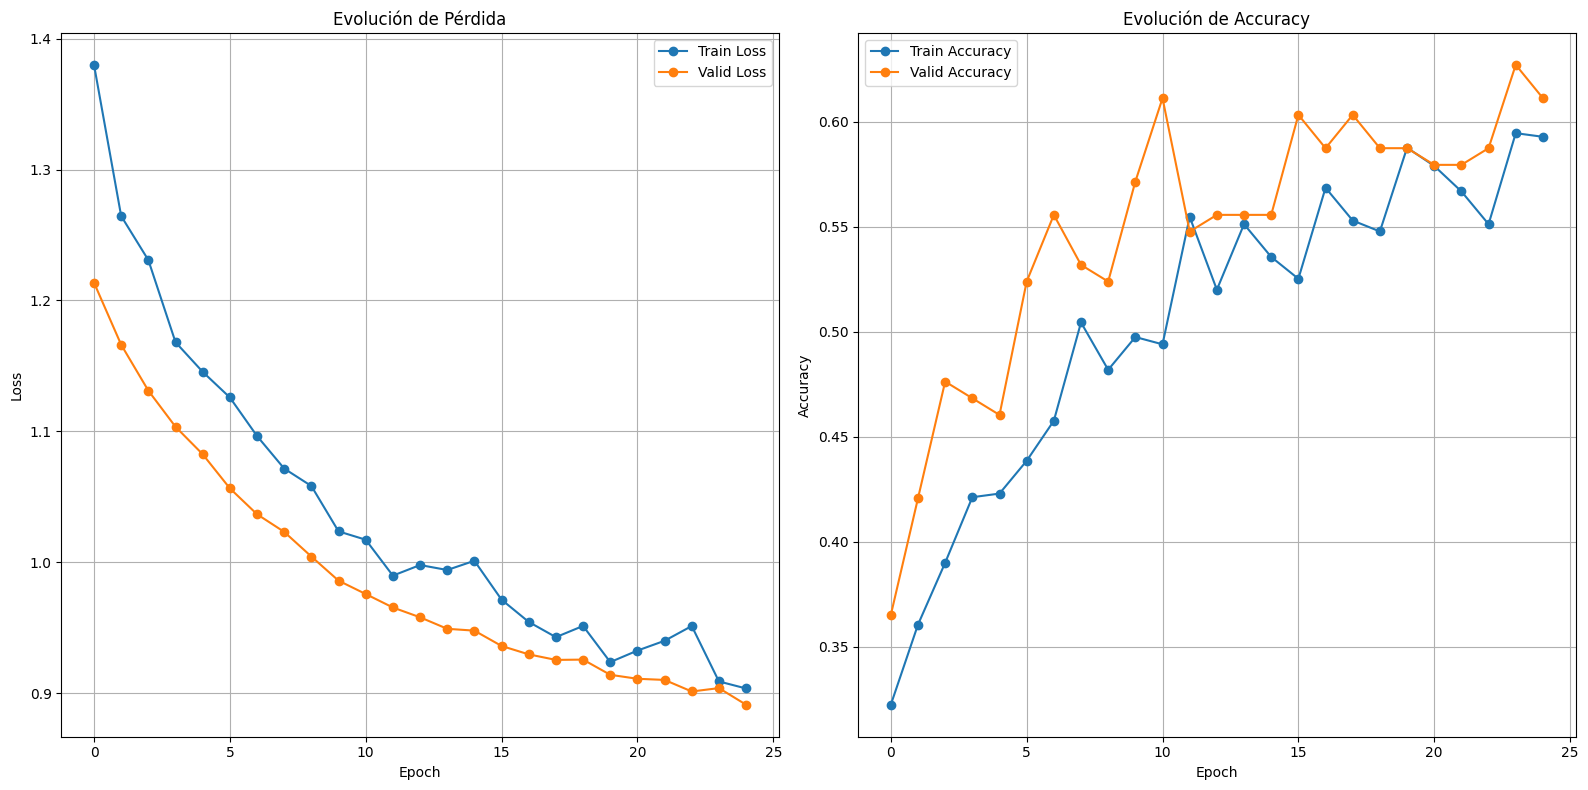

In [16]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss", marker="o")
plt.plot(history["valid_loss"], label="Valid Loss", marker="o")

plt.title("Evolución de Pérdida")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy", marker="o")
plt.plot(history["valid_acc"], label="Valid Accuracy", marker="o")

plt.title("Evolución de Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Evaluación en test

Pérdida y accuracy

In [17]:
test_loss, test_acc = evaluate(vgg16_model, test_loader, loss, device)
print("\nRESULTADOS FINALES EN TEST")
print(f"Test loss: {test_loss:.4f}")
print(f"Test acc : {test_acc:.4f}")


RESULTADOS FINALES EN TEST
Test loss: 0.8927
Test acc : 0.5859


Classification report y matriz de confusión


Classification report (TEST):
                         precision    recall  f1-score   support

         Adenocarcinoma       0.59      0.69      0.64        51
   Large Cell Carcinoma       0.58      0.25      0.35        28
                 Normal       0.90      0.90      0.90        10
Squamous Cell Carcinoma       0.51      0.62      0.56        39

               accuracy                           0.59       128
              macro avg       0.65      0.61      0.61       128
           weighted avg       0.59      0.59      0.57       128



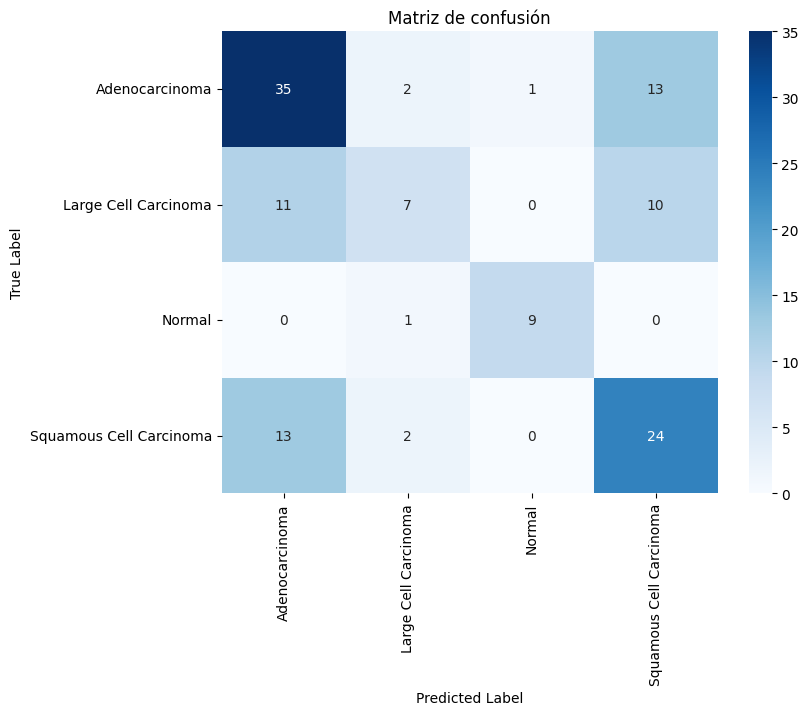

In [18]:
def get_all_preds_and_labels(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_preds_and_labels(vgg16_model, test_loader, device)

print("\nClassification report (TEST):")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matriz de confusión')
plt.show()

## Guardar el modelo entrenado

In [19]:
model_path = data_dir / "vgg16_baseline_best.pth"
torch.save(vgg16_model.state_dict(), model_path)
print(f"\nModelo guardado en: {model_path}")



Modelo guardado en: /content/drive/MyDrive/Data_Clean/vgg16_baseline_best.pth
